# 2016 US Elections Analysis

Importing all the necessary libraries

In [2]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Importing Data

Reading election data file containing the potential attributes across counties which influenced the voting pattern 

In [14]:
election_data = pd.read_csv("US_Election_Data v0.03ma.csv")

Reading State County file containing mapping of state codes to states

In [20]:
State_County = pd.read_csv("State_County_DS.csv")

Removing duplicate state records

In [21]:
State_County_Unique_Records = State_County.groupby(['State','State_Code'],as_index=False).first()

Using Web Scrapping, Collecting Voting Percent of Republic Party and Democratic Party across states and also the total electrol seats won per state

In [4]:
url = ("http://worldpopulationreview.com/states/2016-election-results-by-state/")

In [5]:
page = requests.get(url)

In [6]:
doc = lh.fromstring(page.content)

In [7]:
table_elements = doc.xpath('//tr')

In [8]:
col = []
i=0

In [9]:
for t in table_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

In [10]:
for j in range(1,len(table_elements)):
    T=table_elements[j]
    
    i=0
    
    for t in T.iterchildren():
        data=t.text_content() 
        if i>0:
            try:
                data=int(data)
            except:
                pass
        col[i][1].append(data)
        i+=1

In [11]:
Dict={title:column for (title,column) in col}
seats_won_per_state=pd.DataFrame(Dict)

In [12]:
seats_won_per_state.head()

,State,Votes (D),Vote % (D),Votes (R),Vote % (R),Electoral Votes (D),Electoral Votes (R),2019 Pop.
0,Alabama,"729,547",34.36%,"1,318,255",62.08%,0,9,"4,898,246"
1,Alaska,"116,454",36.55%,"163,387",51.28%,0,3,"735,720"
2,Arizona,"1,161,167",45.13%,"1,252,401",48.67%,0,11,"7,275,070"
3,Arkansas,"380,494",33.65%,"684,872",60.57%,0,6,"3,026,412"
4,California,"8,753,788",61.73%,"4,483,810",31.62%,55,0,"39,747,267"


# Cleaning and Merging Data

Renaming the column names to remove the spaces in the names

In [13]:
seats_won_per_state.columns = ['State','Votes(D)','Vote % (D)','Votes (R)','Vote % (R)','Electoral Votes (D)','Electoral Votes (R)','2019 Pop.']

Merging election data with state county dataset to pull state names 

In [23]:
election_county_state = pd.merge(election_data,State_County_Unique_Records[['State_Code','State']],how = 'left',left_on = 'State',right_on = 'State_Code')

In [24]:
election_county_state.head()

,county,State_x,Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree,Median_Income,Per_votes_Rep,Party_Gov,Voting_Behaviour,State_Code,State_y
0,Autauga County,AL,55221,0.136,93.9,0.335,0.232,51281,0.73,Rep,Rep,AL,Alabama
1,Baldwin County,AL,195121,0.181,95.5,0.288,0.290,50254,0.77,Rep,Rep,AL,Alabama
2,Barbour County,AL,26932,0.161,116.6,0.345,0.125,32964,0.52,Rep,Rep,AL,Alabama
3,Bibb County,AL,22604,0.144,114.6,0.421,0.107,38678,0.77,Rep,Rep,AL,Alabama
4,Blount County,AL,57710,0.166,97.7,0.334,0.129,45813,0.90,Rep,Rep,AL,Alabama


Grouping the election data by states as the further analysis is to be done across states

In [25]:
election_data_per_state = election_county_state.groupby('State_y',as_index = False).agg({'Population_Estimate':['sum'],'Per_Age_over_65':['mean'],'M_per_100_F':['mean'],
                           'Per_high_school_Degree':['mean'],'Per_Bachelor_Degree':['mean'],'Median_Income':['mean'],
                           'Party_Gov':['max']
                          })

In [30]:
election_data_per_state.columns = election_data_per_state.columns.droplevel(1)

Merging election data per state with seats won per state obtained using web scarpping to get vote % across states for various parties

In [33]:
election_analysis_data = pd.merge(election_data_per_state,seats_won_per_state,how = 'left',left_on = 'State_y',right_on = 'State')

Replacing special characters(%) with null for vote % (D) and vote %(R) columns and converting it to float 

In [35]:
election_analysis_data['Vote % (D)'] = election_analysis_data['Vote % (D)'].apply(lambda x: x.replace('%',''))

In [36]:
election_analysis_data['Vote % (D)'] = election_analysis_data['Vote % (D)'].str.strip().astype(float)

In [37]:
election_analysis_data['Vote % (R)'] = election_analysis_data['Vote % (R)'].apply(lambda x: x.replace('%',''))

In [38]:
election_analysis_data['Vote % (R)'] = election_analysis_data['Vote % (R)'].str.strip().astype(float)

# Melting and Reshaping Data

Melting the Electoral Votes(D) and Electoral Votes(R) columns to plot the seat distribution

In [52]:
Votes_per_party = election_analysis_data[['Electoral Votes (D)','Electoral Votes (R)']].melt(value_vars = ['Electoral Votes (D)','Electoral Votes (R)'],
                                                                          var_name = 'Party',value_name = 'Votes')

In [65]:
Votes_per_party.head()

,Party,Votes
0,Electoral Votes (D),0
1,Electoral Votes (D),0
2,Electoral Votes (D),0
3,Electoral Votes (D),0
4,Electoral Votes (D),55


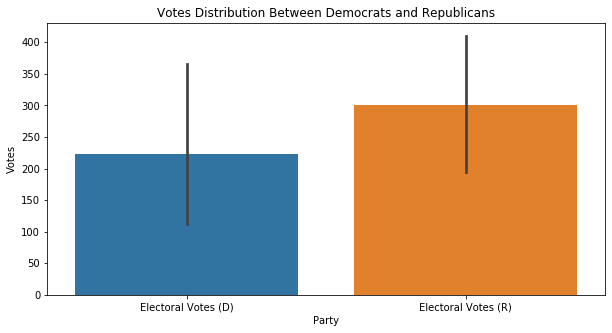

In [77]:
plt.figure(figsize = (10,5))
sns.barplot(x='Party',y='Votes',data= Votes_per_party,estimator = sum);
plt.title("Votes Distribution Between Democrats and Republicans");

It is evident from the above plot that republicans have major share of seats

In [96]:
def voting_behaviour(row):
    if(row['Vote % (D)'] > row['Vote % (R)']):
        return 'Democrats'
    else:
        return 'Republicans'

In [101]:
election_analysis_data['voting_behaviour'] = election_analysis_data.apply(voting_behaviour,axis = 1)

In [127]:
election_analysis_data.groupby('voting_behaviour').agg({'Per_Age_over_65':['min','mean','max'],
                                                            'M_per_100_F':['min','mean','max'],'Per_high_school_Degree':['min','mean','max'],
                                                            'Per_Bachelor_Degree':['min','mean','max'],'Median_Income':['min','mean','max']})

Per_Age_over_65                     M_per_100_F              \
                             min      mean       max         min        mean   
voting_behaviour                                                               
Democrats               0.148619  0.170886  0.195472   93.800000   99.359057   
Republicans             0.095793  0.169978  0.200108   95.050746  101.388299   

                             Per_high_school_Degree                      \
                         max                    min      mean       max   
voting_behaviour                                                          
Democrats         110.717647               0.234879  0.303865  0.356625   
Republicans       120.003448               0.287966  0.356090  0.439673   

                 Per_Bachelor_Degree                     Median_Income  \
                                 min      mean       max           min   
voting_behaviour                                                         
Democrats                   0.176412  0.279720  0.384000  40183.666667   
Republicans                 0.150240  0.193904  0.244043  34938.926829   

                                              
                          mean           max  
voting_behaviour                              
Democrats         56826.753866  73014.095238  
Republicans       45597.375986  64197.103448

On a very high level looking at the above stats, we can comment that states with higher males to female ratios, states with high population proportion of high school degree and low population proportion of Bachelor degree and low median income vote for Republicans

# Feature Engineering

Correlation of various attributes with Vote %(R) are being checked

In [144]:
republic_correlation = election_analysis_data[['Vote % (R)','Population_Estimate','Per_Age_over_65','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree']]

In [145]:

republic_correlation.corr()

,Vote % (R),Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree
Vote % (R),1.000000,-0.282151,0.052434,0.142885,0.592693,-0.690611
Population_Estimate,-0.282151,1.000000,-0.070391,0.091764,-0.141465,-0.062943
Per_Age_over_65,0.052434,-0.070391,1.000000,-0.223740,0.116976,-0.108447
M_per_100_F,0.142885,0.091764,-0.223740,1.000000,-0.033406,-0.262006
Per_high_school_Degree,0.592693,-0.141465,0.116976,-0.033406,1.000000,-0.661801
Per_Bachelor_Degree,-0.690611,-0.062943,-0.108447,-0.262006,-0.661801,1.000000


In [146]:

republic_correlation_matrix = republic_correlation.corr().head(1)

In [147]:
republic_correlation_matrix = republic_correlation_matrix[['Population_Estimate','Per_Age_over_65','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree']]

In [148]:

republic_correlation_matrix

,Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree
Vote % (R),-0.282151,0.052434,0.142885,0.592693,-0.690611


In [149]:
democratic_correlation = election_analysis_data[['Vote % (D)','Population_Estimate','Per_Age_over_65','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree']]

In [150]:
democratic_correlation_matrix = democratic_correlation.corr().head(1)

In [151]:
democratic_correlation_matrix = democratic_correlation_matrix[['Population_Estimate','Per_Age_over_65','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree']]

In [152]:
democratic_correlation_matrix

,Population_Estimate,Per_Age_over_65,M_per_100_F,Per_high_school_Degree,Per_Bachelor_Degree
Vote % (D),0.388008,0.013592,-0.26756,-0.455171,0.611762


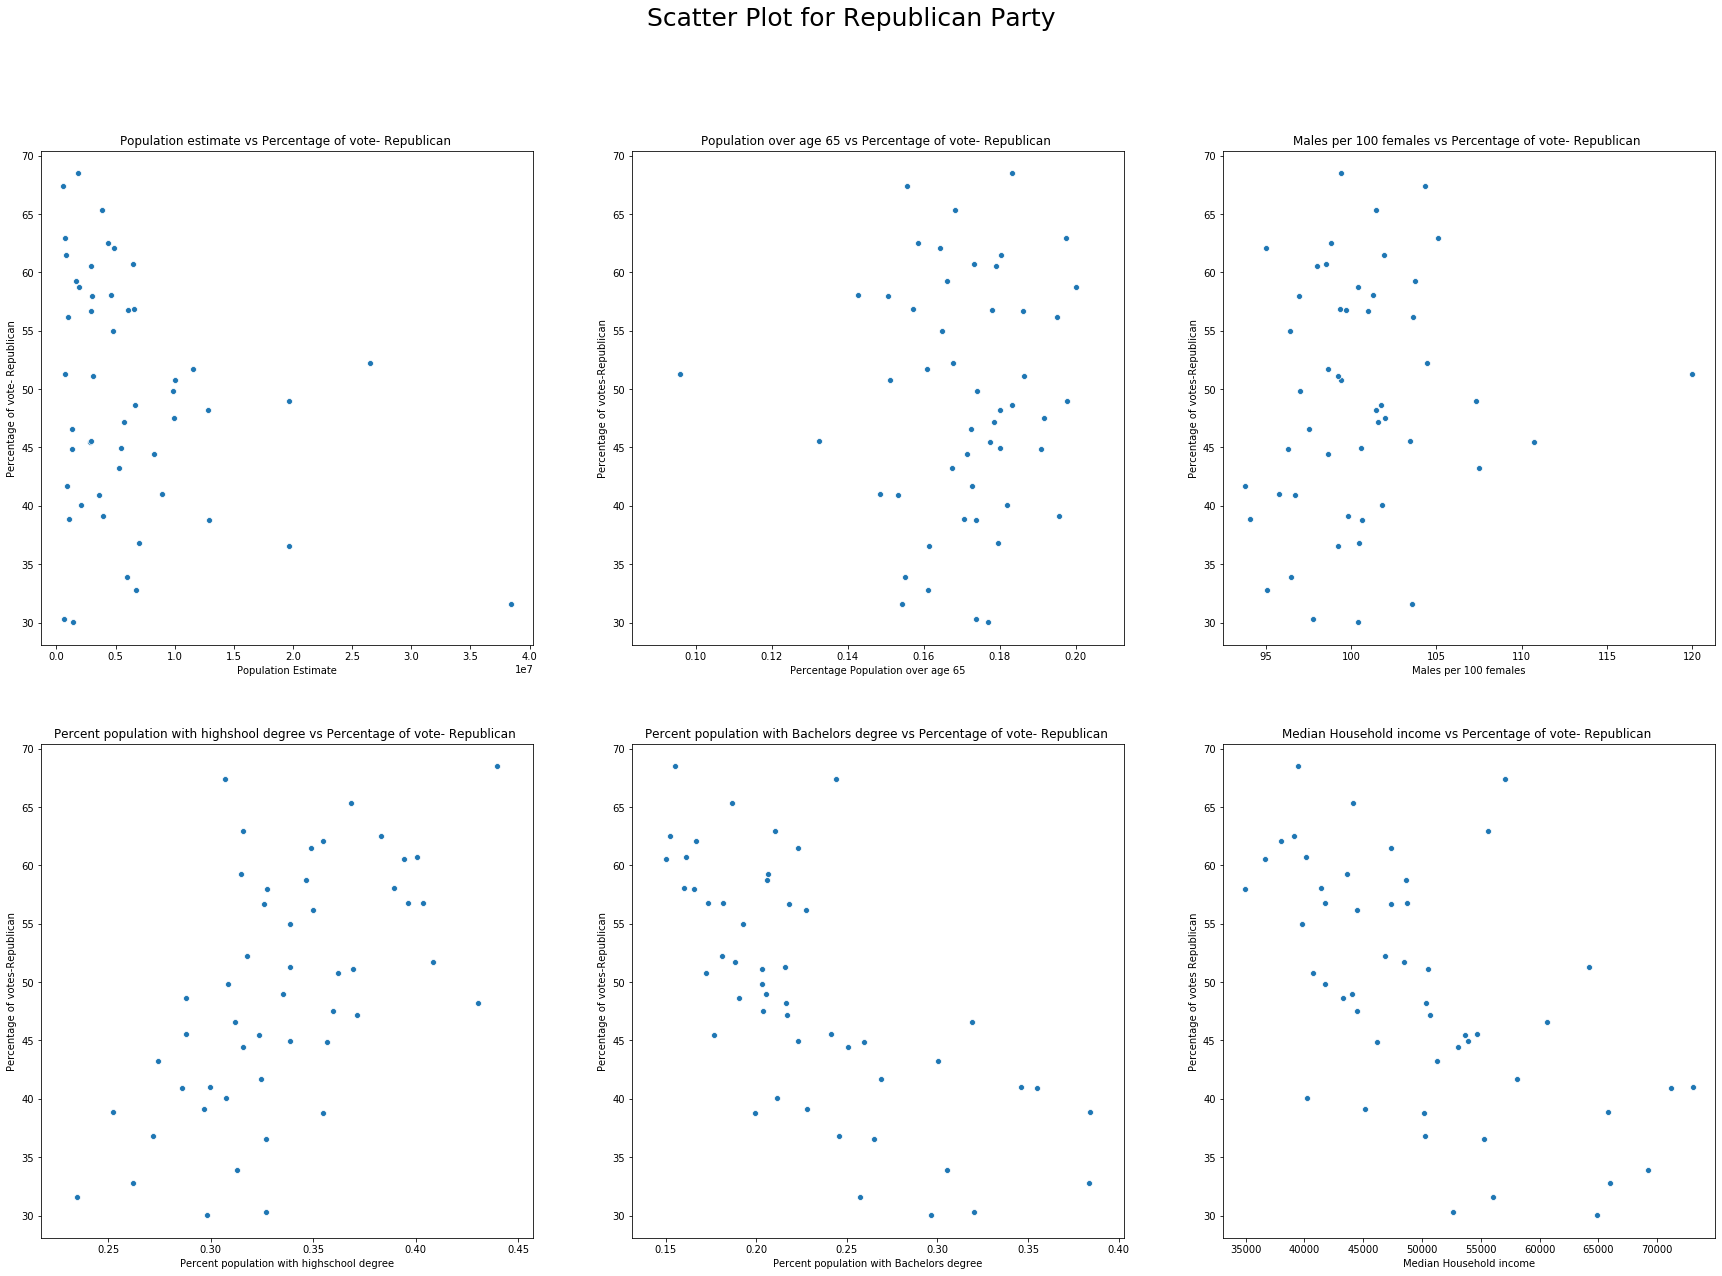

In [153]:
fig, ax = plt.subplots(2,3 ,figsize=(30,20))
fig.suptitle('Scatter Plot for Republican Party',fontsize=25)
sns.scatterplot(x='Population_Estimate', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,0]);
sns.scatterplot(x='Per_Age_over_65', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,1]);
sns.scatterplot(x='M_per_100_F', y='Vote % (R)', data = election_analysis_data ,ax=ax[0,2]);
sns.scatterplot(x='Per_high_school_Degree', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,0]);
sns.scatterplot(x='Per_Bachelor_Degree', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,1]);
sns.scatterplot(x='Median_Income', y='Vote % (R)', data = election_analysis_data ,ax=ax[1,2]);
ax[0,0].set_xlabel('Population Estimate')
ax[0,0].set_ylabel('Percentage of vote- Republican')
ax[0,0].set_title('Population estimate vs Percentage of vote- Republican ')
ax[0,1].set_xlabel('Percentage Population over age 65')
ax[0,1].set_ylabel('Percentage of votes-Republican')
ax[0,1].set_title('Population over age 65 vs Percentage of vote- Republican ')
ax[0,2].set_xlabel('Males per 100 females')
ax[0,2].set_ylabel('Percentage of votes-Republican')
ax[0,2].set_title('Males per 100 females vs Percentage of vote- Republican ')
ax[1,0].set_xlabel('Percent population with highschool degree')
ax[1,0].set_ylabel('Percentage of votes-Republican')
ax[1,0].set_title('Percent population with highshool degree vs Percentage of vote- Republican ')
ax[1,1].set_xlabel('Percent population with Bachelors degree')
ax[1,1].set_ylabel('Percentage of votes-Republican')
ax[1,1].set_title('Percent population with Bachelors degree vs Percentage of vote- Republican ')
ax[1,2].set_xlabel('Median Household income')
ax[1,2].set_ylabel('Percentage of votes Republican');
ax[1,2].set_title('Median Household income vs Percentage of vote- Republican ');

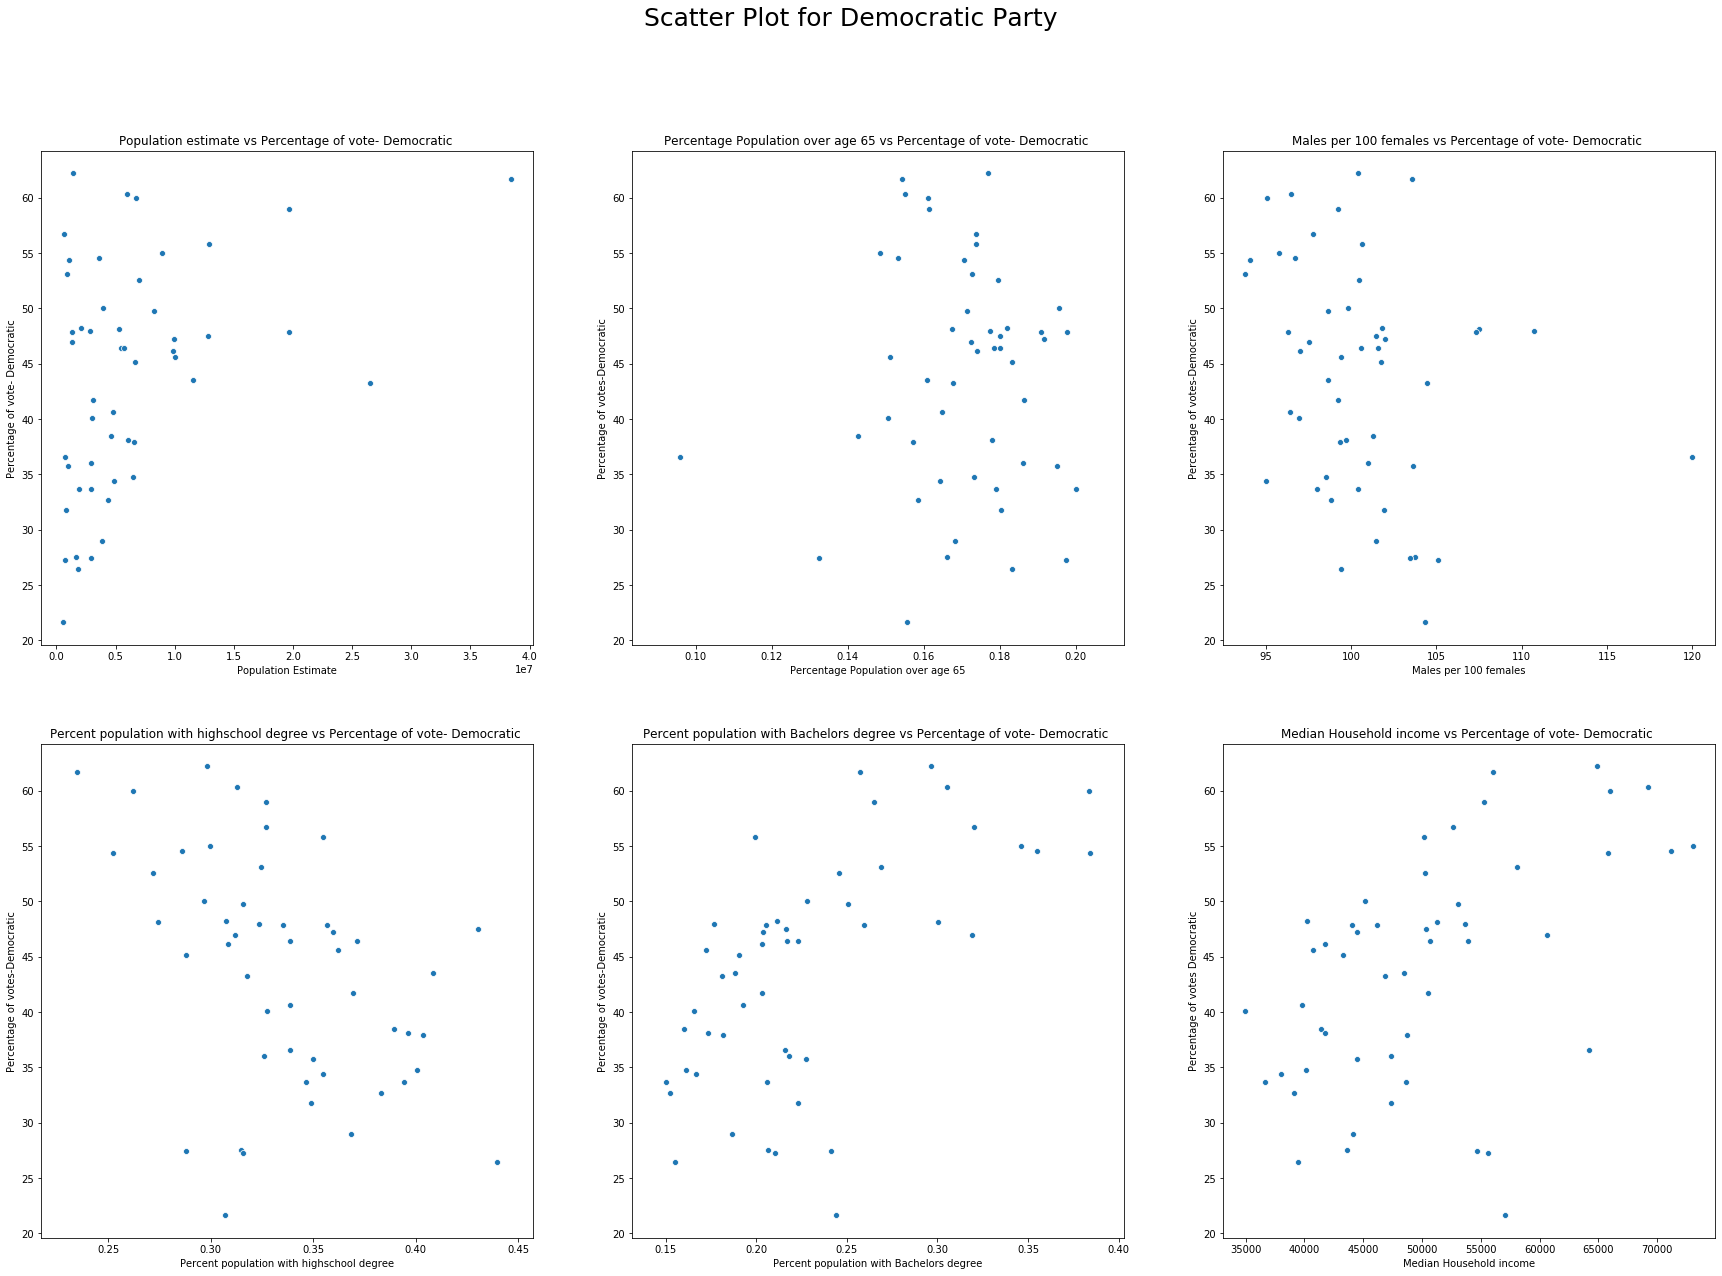

In [154]:
fig, ax = plt.subplots(2,3 ,figsize=(30,20));
fig.suptitle('Scatter Plot for Democratic Party',fontsize=25)
sns.scatterplot(x='Population_Estimate', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,0]);
sns.scatterplot(x='Per_Age_over_65', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,1]);
sns.scatterplot(x='M_per_100_F', y='Vote % (D)', data = election_analysis_data ,ax=ax[0,2]);
sns.scatterplot(x='Per_high_school_Degree', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,0]);
sns.scatterplot(x='Per_Bachelor_Degree', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,1]);
sns.scatterplot(x='Median_Income', y='Vote % (D)', data = election_analysis_data ,ax=ax[1,2]);
ax[0,0].set_xlabel('Population Estimate')
ax[0,0].set_ylabel('Percentage of vote- Democratic')
ax[0,1].set_xlabel('Percentage Population over age 65')
ax[0,1].set_ylabel('Percentage of votes-Democratic')
ax[0,2].set_xlabel('Males per 100 females')
ax[0,2].set_ylabel('Percentage of votes-Democratic')
ax[1,0].set_xlabel('Percent population with highschool degree')
ax[1,0].set_ylabel('Percentage of votes-Democratic')
ax[1,1].set_xlabel('Percent population with Bachelors degree')
ax[1,1].set_ylabel('Percentage of votes-Democratic')
ax[1,2].set_xlabel('Median Household income')
ax[1,2].set_ylabel('Percentage of votes Democratic');
ax[0,0].set_title('Population estimate vs Percentage of vote- Democratic ')
ax[0,1].set_title('Percentage Population over age 65 vs Percentage of vote- Democratic ')
ax[0,2].set_title('Males per 100 females vs Percentage of vote- Democratic ')
ax[1,0].set_title('Percent population with highschool degree vs Percentage of vote- Democratic ')
ax[1,1].set_title('Percent population with Bachelors degree vs Percentage of vote- Democratic ')
ax[1,2].set_title('Median Household income vs Percentage of vote- Democratic ');

# Linear Regression

We have trained our model on the Population Estimate, Male/Female ratio. High School Degree, Bachelors Degree, Mediam Income to get the Vote percent for Republican party as these seems to be correlated with the vote % (R) from the above scatter plots and correlation matrix

In [186]:
X = election_analysis_data[['Population_Estimate','M_per_100_F','Per_high_school_Degree','Per_Bachelor_Degree','Median_Income']]
y = election_analysis_data['Vote % (R)']

In [187]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state = 8451)

In [188]:
model = LinearRegression(fit_intercept = True)

In [189]:
model.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [190]:
model.score(Xtest,ytest)

0.5637301234256824

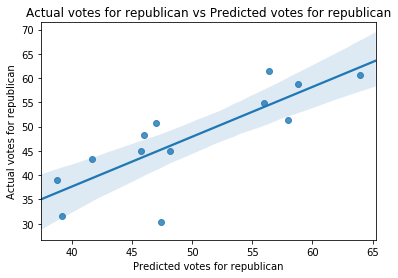

In [191]:
ypredicted = forest.predict(Xtest)
yactual = ytest

sns.regplot(x=ypredicted, y=yactual)
plt.title('Actual votes for republican vs Predicted votes for republican')
plt.xlabel('Predicted votes for republican')
plt.ylabel('Actual votes for republican');

# Lasso Regression

In [192]:
from sklearn.linear_model import Lasso
lasso = Lasso()

In [193]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [194]:
lasso.score(Xtest, ytest)

0.46846714410915247

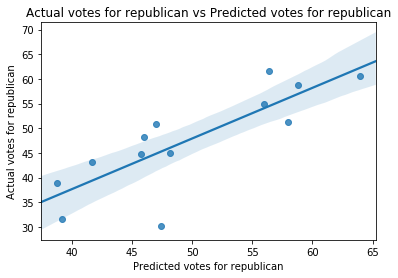

In [195]:
ypredicted = forest.predict(Xtest)
yactual = ytest

sns.regplot(x=ypredicted, y=yactual)
plt.title('Actual votes for republican vs Predicted votes for republican')
plt.xlabel('Predicted votes for republican')
plt.ylabel('Actual votes for republican');

# Random Forest

In [196]:
from sklearn.ensemble import RandomForestRegressor
# Use the default model hyperparameters again.
forest = RandomForestRegressor()

In [197]:
forest.fit(Xtrain, ytrain)

C:\Users\mukka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [198]:
forest.score(Xtest, ytest)

0.6530781745846945

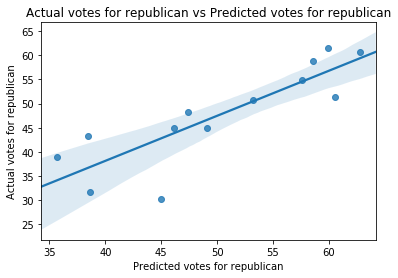

In [199]:
ypredicted = forest.predict(Xtest)
yactual = ytest

sns.regplot(x=ypredicted, y=yactual)
plt.title('Actual votes for republican vs Predicted votes for republican')
plt.xlabel('Predicted votes for republican')
plt.ylabel('Actual votes for republican');